# Bot Entities

(at long last)

Import our libraries needed for the data handling.

In [1]:
import pandas as pd
import numpy as np
import json
import glob

In [2]:
#Set PANDAS to show all columns in DataFrame
pd.set_option('display.max_columns', None)

Libraries for stupid text encoding

In [3]:
from urllib2 import quote
# Unicode strings
from __future__ import unicode_literals
# domain
from urlparse import urlparse

Import libraries needed for visualization.

In [4]:
import matplotlib
import matplotlib.pyplot as plt
# Within notebook viewing
%matplotlib inline

print (matplotlib.__version__)

1.5.3


In [5]:
# Import for axes, color, etc
from pylab import *

### Directories

In [6]:
testDir = '../../data/external/trump-bots/'
botDir = '../../data/external/botresults/'
outDir = '../../data/processed/bot-tweets/'

Read in the data files by combining the extracted files.

In [7]:
# Crudely combine
process = []
for f in glob.glob((botDir + "*.txt")):
    with open(f, "rb") as infile:
        for line in infile:
            process.append(json.loads(line))
raw = pd.DataFrame.from_records(process)

# save memory
del process

print ("(# tweets, # columns): {}".format(raw.shape))

(# tweets, # columns): (77722, 33)


In [9]:
# Helper functions
def countEntities(df, col):
    '''
    Function to aggregate entities from tweets.
    Returns a dataframe with value counts
    '''
    # Hold the entities
    ent_list = []
    
    # assign the appropriate key to get info
    cols = {
        'hashtags': 'text',
        'urls': 'expanded_url',
        'user_mentions': 'screen_name'
    }
    
    def iterEnt(l):
        '''
        Function to keep your sanity. Checks if the entry is null,
        adds values to our list if it isn't.
        '''
        if (l is not None):
            for ent in l:
                try:
                    val = cols[col]
                    if ent[val] is not None:
                        escaped = ent[val].lower().encode('utf-8')
                        ent_list.append(escaped)
                except:
                    print (ent)
    
    df.apply(lambda x: iterEnt(x[col]), axis=1)
    # Create a dataframe, and then aggregate
    counts = pd.DataFrame(pd.Series(ent_list).value_counts())
    counts.reset_index(drop=False, inplace=True)

    # Give it a column
    counts.columns = [col, 'frequency']
    return counts

def countHashtags(tweet):
    try:
        if tweet['hashtags'] is not None:
            return len(tweet['hashtags'])
    except:
        return 0

Extract only the entities. This contains a tweet's hashtags (*#'s*), *URLs*, and user mentions (*@'s*).

In [10]:
# content from tweets
entities = pd.DataFrame.from_records(raw['entities'])    
# Calculate the number of hashtags in a tweet
entities['hashtag_count'] = entities.apply(lambda x: countHashtags(x), axis=1)

print (entities['hashtags'].iloc[3])
entities.head()

[]


,hashtags,media,symbols,trends,urls,user_mentions,hashtag_count
0,"[{u'indices': [126, 136], u'text': u'NoHillary'}]",[{u'source_status_id_str': u'61782112132965990...,[],[],[],"[{u'indices': [3, 17], u'screen_name': u'robin...",1
1,[],NaN,[],[],"[{u'url': u'http://t.co/Ffs3ogVBv8', u'indices...","[{u'indices': [3, 15], u'screen_name': u'Patri...",0
2,"[{u'indices': [84, 94], u'text': u'PressPool'}]",[{u'source_status_id_str': u'61767319763963084...,[],[],[],"[{u'indices': [3, 15], u'screen_name': u'NoahW...",1
3,[],NaN,[],[],"[{u'url': u'http://t.co/pFw88tD4JH', u'indices...",[],0
4,[],NaN,[],[],"[{u'url': u'https://t.co/wAJZe0bcNw', u'indice...","[{u'indices': [3, 18], u'screen_name': u'LessG...",0


### Hashtags

What are the most common hashtags? Summary statistics below.

In [11]:
# Overall bot tweets
print ('Descriptive stats for hashtag counts')
print (entities['hashtag_count'].describe())
print ('\n---\n...for tweets with at least 1 hashtag')
print (entities[entities['hashtag_count'] > 0].describe())

Descriptive stats for hashtag counts
count    77722.000000
mean         0.899050
std          1.430082
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: hashtag_count, dtype: float64

---
...for tweets with at least 1 hashtag
       hashtag_count
count   36897.000000
mean        1.893813
std         1.556955
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        19.000000


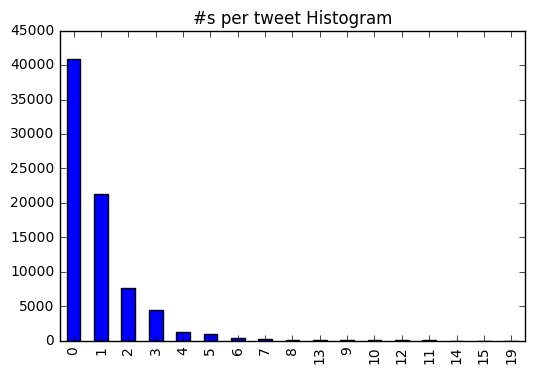

In [12]:
# #'s per tweet distribution
entities['hashtag_count'].value_counts().plot(kind='bar', title='#s per tweet Histogram')

In [26]:
hashtags = countEntities(entities, 'hashtags')
#print (hashtags.head(50))
hashtags.head(50).style.bar(subset=['frequency'], color='#d65f5f')

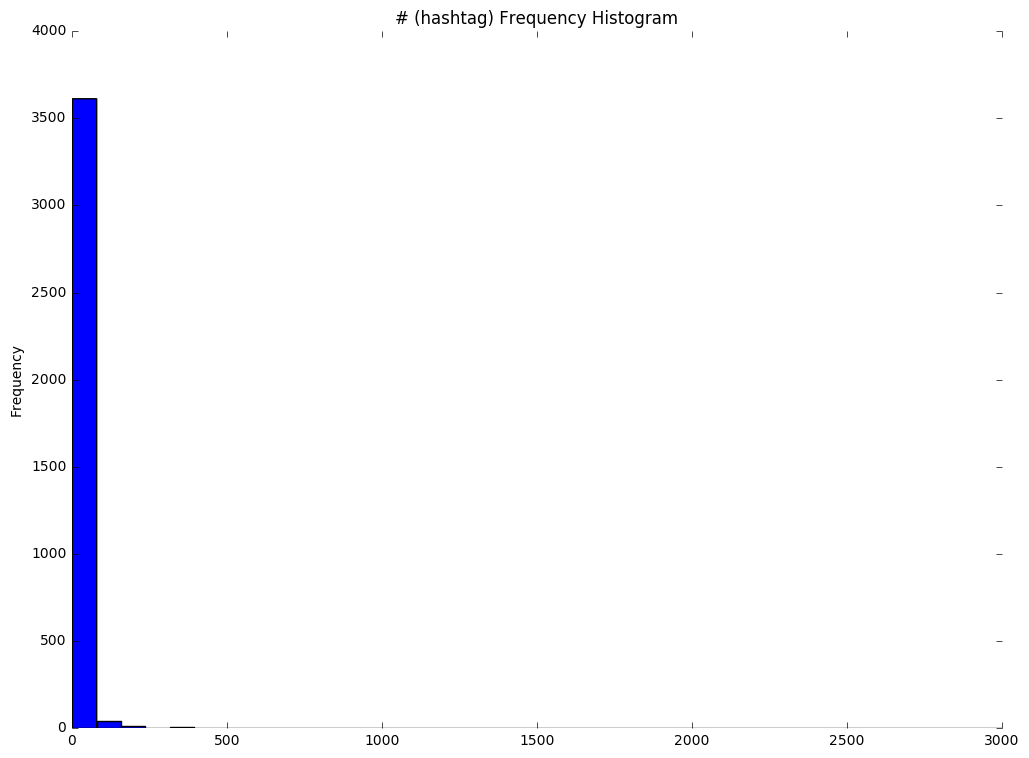

In [14]:
# Distribution of frequencies

# Create a figure of given size
fig = plt.figure(figsize=(12,9))
# Add a subplot
ax = fig.add_subplot(111)
# Remove grid lines (dotted lines inside plot)
ax.grid(False)
# Remove plot frame
ax.set_frame_on(False)

# limit axis so we can see more
matplotlib.pylab.xlim([0, 3000])


hashtags['frequency'].plot(kind='hist', bins=100, title='# (hashtag) Frequency Histogram')

### URLs

In [18]:
def getDomain(url):
    try:
        parsed = urlparse(url)
        domain = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed)
        return domain
    except:
        return Null

In [25]:
urls = countEntities(entities, 'urls')

# aggregate urls
urls['domain'] = urls['urls'].apply(getDomain)

print ('Most popular link')
urls[['urls', 'frequency']].head(50).style.bar(subset=['frequency'], color='#d65f5f')

Most popular link


In [33]:
print ('Most popular domains')
print ('{} unique domains'.format(urls['domain'].unique().size))

# count the urls
domains = urls['domain'].value_counts()
# rename the columns

domains.reset_index(drop=False).head(50)\
    .style.bar(subset=['domain'], color='#d65f5f')

Most popular domains
2341 unique domains


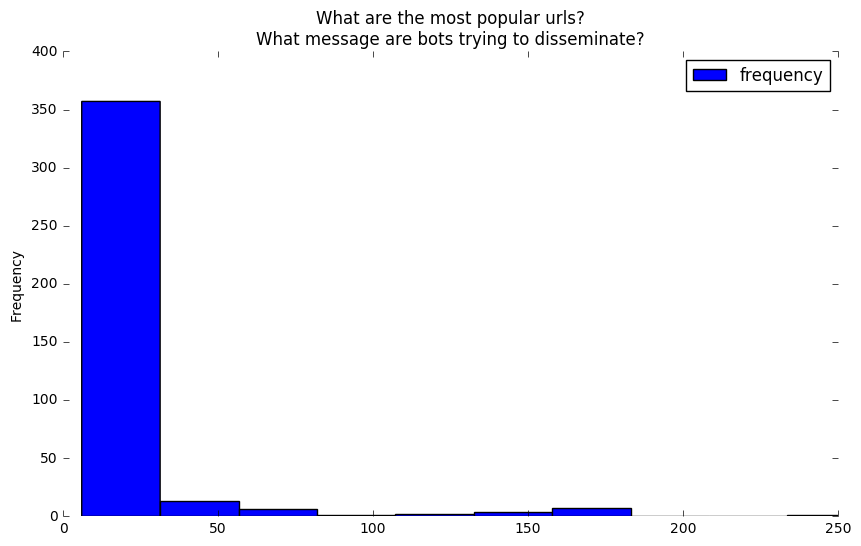

In [38]:
# # distribution of links

# Create a figure and subploy
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Formatting
ax.grid(False)
ax.set_frame_on(False)

# limit axis so we can see more
urls[urls['frequency'] > 5].plot(kind='hist', bins=100, xlim=[0, 250], ax=ax,
                       title='What are the most popular urls?\nWhat message are bots trying to disseminate?')

### Users

In [44]:
users = countEntities(entities, 'user_mentions')
users.head(50).style.bar(subset=['frequency'], color='#d65f5f')

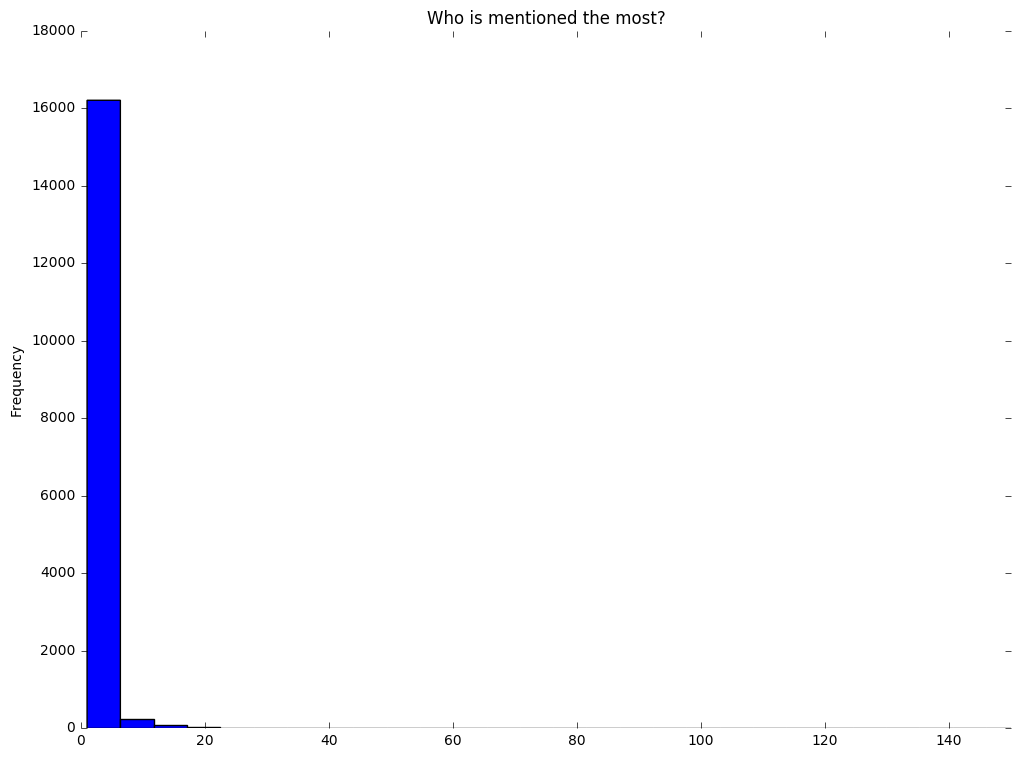

In [42]:
# # distribution of users

# Create a figure and subploy
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)

# Formatting
ax.grid(False)
ax.set_frame_on(False)

# limit axis so we can see more
matplotlib.pylab.xlim([0, users['frequency'].iloc[5:].max()])

# use iloc to skip first two (donaldtrump and youtube)
users['frequency'].iloc[2:].plot(kind='hist', bins=100, xlim=[0, 150],
                       title='Who is mentioned the most?')

In [ ]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh